In [1]:
# ============
# 0) SETUP
# ============

import os, math, random, gc
from pathlib import Path
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Reproducibility and performance
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Local Windows paths: adjust as needed
CSV_PATH = r"C:/Users/chait/Downloads/melanoma_classification/data/train.csv"
IMG_DIR  = Path(r"C:/Users/chait/Downloads/melanoma_classification/data/jpeg/train")

assert os.path.isfile(CSV_PATH), f"CSV not found: {CSV_PATH}"
assert IMG_DIR.exists(), f"Image dir not found: {IMG_DIR}"

# Helpers
def roc_pr(y_true, y_prob):
    auc = roc_auc_score(y_true, y_prob)
    ap  = average_precision_score(y_true, y_prob)
    return auc, ap

def pos_weight_from_labels(y):
    pos = y.sum()
    neg = len(y) - pos
    return float(np.sqrt((neg + 1e-6) / (pos + 1e-6)))


In [2]:
# ==========================
# 1) LOAD & PREPROCESS DATA
# ==========================

df = pd.read_csv(CSV_PATH, low_memory=False)

print("Dataset shape:", df.shape)
print("Columns:", list(df.columns))
print("Missing values (%):")
print((df.isnull().mean().sort_values(ascending=False) * 100).round(2))
print("\nNumeric summary:")
print(df.describe(include=[float, int]))

# Minimal, consistent imputation and vocab
df["sex"] = df["sex"].fillna("Unknown")
df["anatom_site_general_challenge"] = df["anatom_site_general_challenge"].fillna("Unknown")
df["age_approx"] = df["age_approx"].fillna(df["age_approx"].median())

cat_cols = ["sex", "anatom_site_general_challenge"]
cat_vocab = {}
for c in cat_cols:
    cats = sorted(df[c].astype(str).unique().tolist())
    cat_vocab[c] = {v:i for i,v in enumerate(cats)}

def build_meta_features(ddf: pd.DataFrame) -> np.ndarray:
    sex_idx  = ddf["sex"].astype(str).map(cat_vocab["sex"]).astype(int).values
    site_idx = ddf["anatom_site_general_challenge"].astype(str).map(cat_vocab["anatom_site_general_challenge"]).astype(int).values
    sex_oh  = np.eye(len(cat_vocab["sex"]), dtype=np.float32)[sex_idx]
    site_oh = np.eye(len(cat_vocab["anatom_site_general_challenge"]), dtype=np.float32)[site_idx]
    age = np.clip(ddf["age_approx"].values.astype(np.float32) / 100.0, 0.0, 1.0).reshape(-1,1)
    return np.concatenate([age, sex_oh, site_oh], axis=1).astype(np.float32)

meta = build_meta_features(df)
META_DIM = meta.shape[1]
print(f"Metadata dimension: {META_DIM}")


Dataset shape: (33126, 8)
Columns: ['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge', 'diagnosis', 'benign_malignant', 'target']
Missing values (%):
anatom_site_general_challenge    1.59
age_approx                       0.21
sex                              0.20
patient_id                       0.00
image_name                       0.00
diagnosis                        0.00
benign_malignant                 0.00
target                           0.00
dtype: float64

Numeric summary:
         age_approx        target
count  33058.000000  33126.000000
mean      48.870016      0.017630
std       14.380360      0.131603
min        0.000000      0.000000
25%       40.000000      0.000000
50%       50.000000      0.000000
75%       60.000000      0.000000
max       90.000000      1.000000
Metadata dimension: 11


In [3]:
# ======================================
# 2) PATIENT-GROUPED STRATIFIED 5-FOLDS
# ======================================

assert "patient_id" in df.columns and "target" in df.columns, "Expected patient_id and target in CSV."

pt = df.groupby("patient_id").agg(n=("image_name","count"), y=("target","max")).reset_index()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pt["fold"] = -1
for fold, (_, val_idx) in enumerate(skf.split(pt, pt["y"])):
    pt.loc[val_idx, "fold"] = fold

df = df.merge(pt[["patient_id","fold"]], on="patient_id", how="left")
print("Fold sizes (image counts):\n", df["fold"].value_counts().sort_index())
print("Pos rate overall:", df["target"].mean())


Fold sizes (image counts):
 fold
0    5899
1    7046
2    6538
3    6902
4    6741
Name: count, dtype: int64
Pos rate overall: 0.01762965646320111


In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np

IMG_SIZE = 448
MEAN, STD = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_tfms = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE, interpolation=cv2.INTER_CUBIC),
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=cv2.BORDER_REFLECT_101),
    # IMPORTANT: use size=(h, w) to satisfy validation in newer Albumentations
    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.85, 1.0), ratio=(0.9, 1.1), p=0.8),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.10, rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.7),
    A.CLAHE(p=0.2),
    A.RandomBrightnessContrast(p=0.3),
    A.CoarseDropout(
        max_holes=1,
        max_height=int(IMG_SIZE * 0.25),
        max_width=int(IMG_SIZE * 0.25),
        fill_value=0,
        p=0.5
    ),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

valid_tfms = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE, interpolation=cv2.INTER_CUBIC),
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=cv2.BORDER_REFLECT_101),
    # Center crop with size tuple as well
    A.CenterCrop(height=IMG_SIZE, width=IMG_SIZE, p=1.0),  # if your version still needs size, switch to: size=(IMG_SIZE, IMG_SIZE)
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])


C:\Users\chait\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\chait\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\chait\AppData\Local\Temp\ipykernel_26208\1086364489.py:19: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


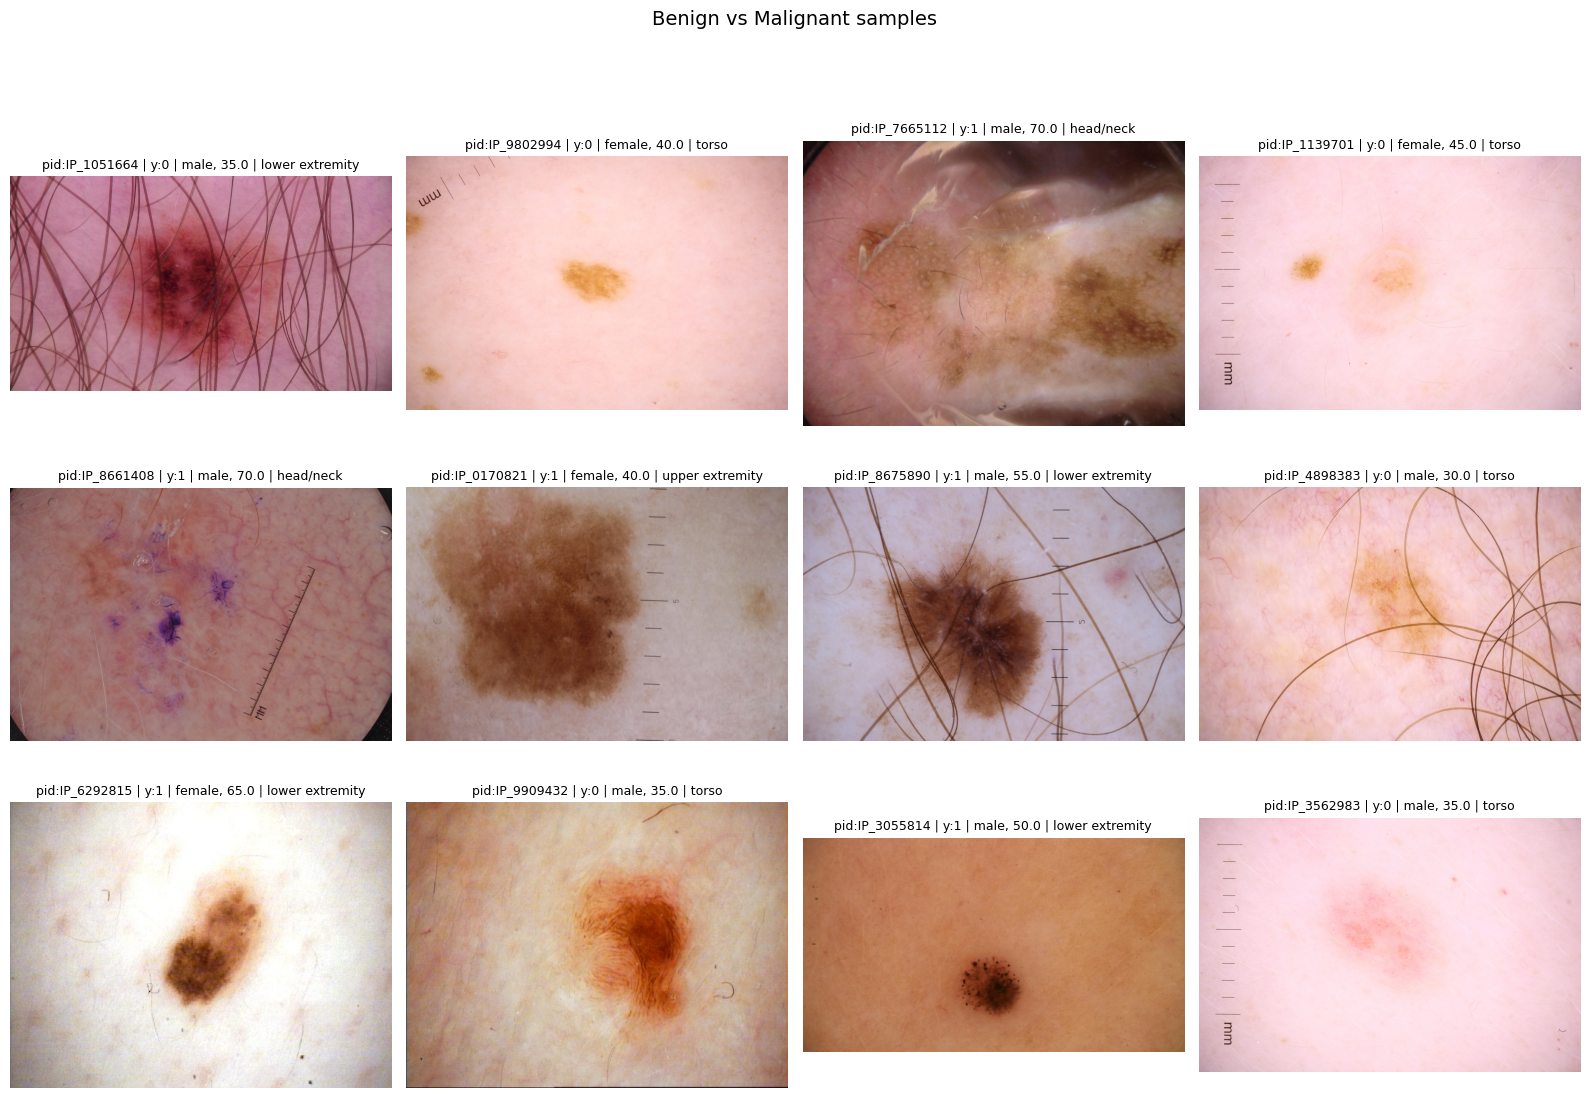

In [5]:
# =====================
# 4) SHOWCASE IMAGES
# =====================

def show_images_grid(df_in, img_dir, n=12, cols=4, title="Sample dermoscopy images", seed=42):
    random.seed(seed)
    df_disp = df_in.copy()
    pos = df_disp[df_disp["target"] == 1]
    neg = df_disp[df_disp["target"] == 0]
    n_pos = min(len(pos), n // 2)
    n_neg = min(len(neg), n - n_pos)
    df_sample = pd.concat([
        pos.sample(n=n_pos, random_state=seed) if n_pos > 0 else pos.head(0),
        neg.sample(n=n_neg, random_state=seed) if n_neg > 0 else neg.head(0),
    ], axis=0).sample(frac=1.0, random_state=seed).reset_index(drop=True)
    if len(df_sample) < n and len(df_disp) > len(df_sample):
        df_sample = pd.concat([df_sample, df_disp.sample(n=n-len(df_sample), random_state=seed)], axis=0)

    rows = math.ceil(len(df_sample) / cols)
    plt.figure(figsize=(4*cols, 4*rows))
    for i, row in enumerate(df_sample.itertuples(), 1):
        path = Path(img_dir) / f"{row.image_name}.jpg"
        img = cv2.imread(str(path))
        if img is None:
            img = np.zeros((512, 512, 3), dtype=np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i)
        plt.imshow(img); plt.axis("off")
        meta_str = f"pid:{row.patient_id} | y:{row.target} | {getattr(row,'sex','?')}, {getattr(row,'age_approx','?')} | {getattr(row,'anatom_site_general_challenge','?')}"
        plt.title(meta_str, fontsize=9)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Example: preview a mix of benign/malignant
show_images_grid(df, IMG_DIR, n=12, cols=4, title="Benign vs Malignant samples")


In [6]:
# ===========================
# 5) METADATA-ONLY BASELINE
# ===========================

class MetaMLP(nn.Module):
    def __init__(self, dim_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim_in, 64), nn.ReLU(True), nn.BatchNorm1d(64), nn.Dropout(0.2),
            nn.Linear(64, 32), nn.ReLU(True), nn.BatchNorm1d(32), nn.Dropout(0.1),
            nn.Linear(32, 1)
        )
    def forward(self, m): return self.net(m).squeeze(1)

def train_meta_fold(train_loader, valid_loader, epochs=8, lr=1e-3, pos_weight=1.0):
    model = MetaMLP(META_DIM).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=DEVICE))
    best_auc, best_p, best_y = -1, None, None
    for ep in range(epochs):
        model.train()
        for _, mb, yb in train_loader:
            mb, yb = mb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logit = model(mb)
            loss = bce(logit, yb)
            loss.backward(); opt.step()
        model.eval(); probs=[]; ys=[]
        with torch.no_grad():
            for _, mva, yva in valid_loader:
                p = torch.sigmoid(model(mva.to(DEVICE))).cpu().numpy()
                probs.append(p); ys.append(yva.numpy())
        y = np.concatenate(ys); p = np.concatenate(probs)
        auc, ap = roc_pr(y, p)
        if auc > best_auc: best_auc, best_p, best_y = auc, p, y
        print(f"[Meta] ep {ep} AUC {auc:.4f} | AP {ap:.4f}")
    return best_auc, best_y, best_p


In [34]:
pip install timm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: C:\Users\chait\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [35]:
# ======================================
# 6) IMAGE + METADATA CNN (EfficientNet)
# ======================================

# If timm is not installed, uncomment:
# %pip install timm -q

import timm
from torch.cuda.amp import autocast, GradScaler

class ImgMetaModel(nn.Module):
    def __init__(self, backbone="tf_efficientnet_b4_ns", meta_dim=META_DIM, dropout=0.3, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(backbone, pretrained=pretrained, num_classes=0, global_pool="avg")
        feat_dim = self.backbone.num_features
        self.img_do = nn.Dropout(dropout)
        self.meta = nn.Sequential(
            nn.Linear(meta_dim, 64), nn.ReLU(True), nn.BatchNorm1d(64), nn.Dropout(0.2),
            nn.Linear(64, 32), nn.ReLU(True)
        )
        self.head = nn.Sequential(
            nn.Linear(feat_dim + 32, 256), nn.ReLU(True), nn.Dropout(0.3),
            nn.Linear(256, 1)
        )
    def forward(self, x, m):
        f = self.img_do(self.backbone(x))
        g = self.meta(m)
        z = torch.cat([f, g], dim=1)
        return self.head(z).squeeze(1)

def train_one_fold(train_loader, valid_loader, epochs=6, lr=3e-4, pos_weight=1.0, backbone="tf_efficientnet_b4_ns"):
    model = ImgMetaModel(backbone=backbone, meta_dim=META_DIM, pretrained=True).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=DEVICE))
    scaler = GradScaler()
    best_auc, best_p, best_y = -1, None, None

    for ep in range(epochs):
        model.train()
        for xb, mb, yb in train_loader:
            xb, mb, yb = xb.to(DEVICE), mb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            with autocast():
                logit = model(xb, mb)
                loss = bce(logit, yb)
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()

        model.eval(); probs=[]; ys=[]
        with torch.no_grad():
            for xb, mb, yb in valid_loader:
                p = torch.sigmoid(model(xb.to(DEVICE), mb.to(DEVICE))).cpu().numpy()
                probs.append(p); ys.append(yb.numpy())
        y = np.concatenate(ys); p = np.concatenate(probs)
        auc, ap = roc_pr(y, p)
        if auc > best_auc: best_auc, best_p, best_y = auc, p, y
        print(f"[Img+Meta] ep {ep} AUC {auc:.4f} | AP {ap:.4f}")
    return best_auc, best_y, best_p


In [7]:
import inspect, albumentations as A

print("Albumentations version:", A.__version__)
print("RandomResizedCrop signature:", inspect.signature(A.RandomResizedCrop.__init__))
print("CenterCrop signature:", inspect.signature(A.CenterCrop.__init__))

# Pick a valid image path from your dataset
test_path = IMG_DIR / f"{df.iloc[0].image_name}.jpg"
img = cv2.imread(str(test_path))
if img is None:
    raise FileNotFoundError(f"Test image not found: {test_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

out_train = train_tfms(image=img)["image"]
out_valid = valid_tfms(image=img)["image"]
print("Train tensor shape:", tuple(out_train.shape))  # Expect (3, 448, 448)
print("Valid tensor shape:", tuple(out_valid.shape))  # Expect (3, 448, 448)


Albumentations version: 2.0.8
RandomResizedCrop signature: (self, size: 'tuple[int, int]', scale: 'tuple[float, float]' = (0.08, 1.0), ratio: 'tuple[float, float]' = (0.75, 1.3333333333333333), interpolation: 'Literal[cv2.INTER_NEAREST, cv2.INTER_NEAREST_EXACT, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA, cv2.INTER_LANCZOS4, cv2.INTER_LINEAR_EXACT]' = 1, mask_interpolation: 'Literal[cv2.INTER_NEAREST, cv2.INTER_NEAREST_EXACT, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA, cv2.INTER_LANCZOS4, cv2.INTER_LINEAR_EXACT]' = 0, area_for_downscale: "Literal[None, 'image', 'image_mask']" = None, p: 'float' = 1.0)
CenterCrop signature: (self, height: 'int', width: 'int', pad_if_needed: 'bool' = False, pad_position: "Literal['center', 'top_left', 'top_right', 'bottom_left', 'bottom_right', 'random']" = 'center', border_mode: 'Literal[cv2.BORDER_CONSTANT, cv2.BORDER_REPLICATE, cv2.BORDER_REFLECT, cv2.BORDER_WRAP, cv2.BORDER_REFLECT_101]' = 0, fill: 'tuple[float, ...] | float' = 0.0, fill

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

IMG_SIZE = 448
MEAN, STD = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_tfms = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE, interpolation=cv2.INTER_CUBIC),
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=cv2.BORDER_REFLECT_101),
    # Albumentations 2.0.8 requires size=(h, w) for RandomResizedCrop
    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.85, 1.0), ratio=(0.9, 1.1), p=0.8),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.10, rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.7),
    A.CLAHE(p=0.2),
    A.RandomBrightnessContrast(p=0.3),
    A.CoarseDropout(
        max_holes=1,
        max_height=int(IMG_SIZE * 0.25),
        max_width=int(IMG_SIZE * 0.25),
        fill_value=0,
        p=0.5
    ),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

valid_tfms = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE, interpolation=cv2.INTER_CUBIC),
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=cv2.BORDER_REFLECT_101),
    # CenterCrop in 2.0.8 requires height and width (not size=)
    A.CenterCrop(height=IMG_SIZE, width=IMG_SIZE, p=1.0),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

C:\Users\chait\AppData\Local\Temp\ipykernel_26208\1483937275.py:18: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


In [9]:
# ===========================
# 5) METADATA-ONLY BASELINE
# ===========================
import torch
import torch.nn as nn
import torch.nn.functional as F

class MetaMLP(nn.Module):
    def __init__(self, dim_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim_in, 64), nn.ReLU(True), nn.BatchNorm1d(64), nn.Dropout(0.2),
            nn.Linear(64, 32), nn.ReLU(True), nn.BatchNorm1d(32), nn.Dropout(0.1),
            nn.Linear(32, 1)
        )
    def forward(self, m): 
        return self.net(m).squeeze(1)

from sklearn.metrics import roc_auc_score, average_precision_score

def roc_pr(y_true, y_prob):
    auc = roc_auc_score(y_true, y_prob)
    ap  = average_precision_score(y_true, y_prob)
    return auc, ap

def pos_weight_from_labels(y):
    y = y.astype(np.float32)
    pos = y.sum()
    neg = len(y) - pos
    return float(np.sqrt((neg + 1e-6) / (pos + 1e-6)))

def train_meta_fold(train_loader, valid_loader, epochs=8, lr=1e-3, pos_weight=1.0, device=DEVICE):
    model = MetaMLP(META_DIM).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))
    best_auc, best_p, best_y = -1, None, None
    for ep in range(epochs):
        model.train()
        for _, mb, yb in train_loader:
            mb, yb = mb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            logit = model(mb)
            loss = bce(logit, yb)
            loss.backward(); opt.step()
        # validation
        model.eval(); probs=[]; ys=[]
        with torch.no_grad():
            for _, mva, yva in valid_loader:
                p = torch.sigmoid(model(mva.to(device))).cpu().numpy()
                probs.append(p); ys.append(yva.numpy())
        y = np.concatenate(ys); p = np.concatenate(probs)
        auc, ap = roc_pr(y, p)
        if auc > best_auc:
            best_auc, best_p, best_y = auc, p, y
        print(f"[Meta] ep {ep} AUC {auc:.4f} | AP {ap:.4f}")
    return best_auc, best_y, best_p


In [10]:
# ======================================
# 6) IMAGE + METADATA CNN (EfficientNet)
# ======================================
# If timm is not installed, run: %pip install timm -q
import timm
from torch.cuda.amp import autocast, GradScaler

class ImgMetaModel(nn.Module):
    def __init__(self, backbone="tf_efficientnet_b4_ns", meta_dim=META_DIM, dropout=0.3, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(backbone, pretrained=pretrained, num_classes=0, global_pool="avg")
        feat_dim = self.backbone.num_features
        self.img_do = nn.Dropout(dropout)
        self.meta = nn.Sequential(
            nn.Linear(meta_dim, 64), nn.ReLU(True), nn.BatchNorm1d(64), nn.Dropout(0.2),
            nn.Linear(64, 32), nn.ReLU(True)
        )
        self.head = nn.Sequential(
            nn.Linear(feat_dim + 32, 256), nn.ReLU(True), nn.Dropout(0.3),
            nn.Linear(256, 1)
        )
    def forward(self, x, m):
        f = self.img_do(self.backbone(x))
        g = self.meta(m)
        z = torch.cat([f, g], dim=1)
        return self.head(z).squeeze(1)

def train_one_fold(train_loader, valid_loader, epochs=6, lr=3e-4, pos_weight=1.0, backbone="tf_efficientnet_b4_ns", device=DEVICE):
    model = ImgMetaModel(backbone=backbone, meta_dim=META_DIM, pretrained=True).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))
    scaler = GradScaler()
    best_auc, best_p, best_y = -1, None, None

    for ep in range(epochs):
        model.train()
        for xb, mb, yb in train_loader:
            xb, mb, yb = xb.to(device), mb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            with autocast():
                logit = model(xb, mb)
                loss = bce(logit, yb)
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()

        # validation
        model.eval(); probs=[]; ys=[]
        with torch.no_grad():
            for xb, mb, yb in valid_loader:
                p = torch.sigmoid(model(xb.to(device), mb.to(device))).cpu().numpy()
                probs.append(p); ys.append(yb.numpy())
        y = np.concatenate(ys); p = np.concatenate(probs)
        auc, ap = roc_pr(y, p)
        if auc > best_auc:
            best_auc, best_p, best_y = auc, p, y
        print(f"[Img+Meta] ep {ep} AUC {auc:.4f} | AP {ap:.4f}")
    return best_auc, best_y, best_p


In [ ]:
# ==========================================
# 7) 5-FOLD CV TRAINING & OOF EVALUATION
# ==========================================
import time
from collections import defaultdict

FOLDS = sorted(df["fold"].unique().tolist())
y_all = df["target"].values.astype(np.float32)
oof_meta = np.zeros(len(df), dtype=np.float32)
oof_imgm = np.zeros(len(df), dtype=np.float32)

def fold_stats(df_fold):
    n = len(df_fold)
    p = int(df_fold["target"].sum())
    return n, p, n - p

for fold in FOLDS:
    print(f"\n=== Fold {fold} ===")
    train_loader, valid_loader, trn_idx, val_idx = make_loaders_for_fold(fold, batch_size=16)
    n_tr, p_tr, n_trn = fold_stats(df.iloc[trn_idx])
    n_va, p_va, n_van = fold_stats(df.iloc[val_idx])
    print(f"Train: N={n_tr} | pos={p_tr} | neg={n_trn} | pos_rate={p_tr/max(1,n_tr):.4f}")
    print(f"Valid: N={n_va} | pos={p_va} | neg={n_van} | pos_rate={p_va/max(1,n_va):.4f}")

    pos_w = pos_weight_from_labels(df.iloc[trn_idx]["target"].values)

    t0 = time.time()
    best_auc_meta, yv_m, pv_m = train_meta_fold(train_loader, valid_loader, epochs=8, lr=1e-3, pos_weight=pos_w)
    if pv_m is None:
        pv_m = np.zeros(len(val_idx), dtype=np.float32)
    oof_meta[val_idx] = pv_m
    print(f"[Meta] Fold {fold} best AUC: {best_auc_meta:.4f} | time {time.time()-t0:.1f}s")

    t1 = time.time()
    best_auc_imgm, yv_i, pv_i = train_one_fold(train_loader, valid_loader, epochs=6, lr=3e-4, pos_weight=pos_w, backbone="tf_efficientnet_b4_ns")
    if pv_i is None:
        pv_i = np.zeros(len(val_idx), dtype=np.float32)
    oof_imgm[val_idx] = pv_i
    print(f"[Img+Meta] Fold {fold} best AUC: {best_auc_imgm:.4f} | time {time.time()-t1:.1f}s")

# Overall OOF metrics
auc_meta, ap_meta = roc_pr(y_all, oof_meta)
auc_imgm, ap_imgm = roc_pr(y_all, oof_imgm)
print(f"\nOOF Meta-only AUC {auc_meta:.4f} | AP {ap_meta:.4f}")
print(f"OOF Img+Meta  AUC {auc_imgm:.4f} | AP {ap_imgm:.4f}")



=== Fold 0 ===
Train: N=27227 | pos=474 | neg=26753 | pos_rate=0.0174
Valid: N=5899 | pos=110 | neg=5789 | pos_rate=0.0186


In [12]:
# ===== Define transforms, Dataset, and make_loaders_for_fold (Albumentations 2.0.8) =====
import os, numpy as np, cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader

# Preconditions: df (with columns: image_name, target, fold), meta (np.ndarray), and IMG_DIR must exist
assert 'df' in globals(), "df is not defined. Load your CSV and build folds first."
assert 'meta' in globals(), "meta is not defined. Build your metadata feature matrix first."
assert 'IMG_DIR' in globals(), "IMG_DIR is not defined. Set your image directory path first."

IMG_SIZE = 448
MEAN, STD = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

# Albumentations 2.0.8 signatures:
# - RandomResizedCrop(size=(h,w), ...)
# - CenterCrop(height=, width=, ...)
train_tfms = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE, interpolation=cv2.INTER_CUBIC),
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=cv2.BORDER_REFLECT_101),
    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.85, 1.0), ratio=(0.9, 1.1), p=0.8),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.10, rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.7),
    A.CLAHE(p=0.2),
    A.RandomBrightnessContrast(p=0.3),
    A.CoarseDropout(max_holes=1, max_height=int(IMG_SIZE*0.25), max_width=int(IMG_SIZE*0.25), fill_value=0, p=0.5),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

valid_tfms = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE, interpolation=cv2.INTER_CUBIC),
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=cv2.BORDER_REFLECT_101),
    A.CenterCrop(height=IMG_SIZE, width=IMG_SIZE, p=1.0),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

class MelanomaDataset(Dataset):
    """
    Returns: (image_tensor, meta_tensor, target_float)
    Expects df with columns: image_name, target
    """
    def __init__(self, df_in, img_dir, meta_array, tfms):
        self.df = df_in.reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.meta = meta_array
        self.tfms = tfms

    def __len__(self): 
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.img_dir / f"{row.image_name}.jpg"
        img = cv2.imread(str(img_path))
        if img is None:
            img = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.tfms(image=img)["image"]
        m = torch.tensor(self.meta[idx], dtype=torch.float32)
        y = torch.tensor(row.target, dtype=torch.float32)
        return img, m, y

def make_loaders_for_fold(fold, batch_size=16, num_workers=4, pin_memory=True):
    """
    Create train/valid DataLoaders for a given fold using global df/meta/IMG_DIR.
    Returns: train_loader, valid_loader, trn_idx, val_idx
    """
    fold_arr = df["fold"].values
    trn_idx = np.where(fold_arr != fold)[0]
    val_idx = np.where(fold_arr == fold)

    dtr, dva = df.iloc[trn_idx], df.iloc[val_idx]
    mtr, mva = meta[trn_idx], meta[val_idx]

    train_ds = MelanomaDataset(dtr, IMG_DIR, mtr, train_tfms)
    valid_ds = MelanomaDataset(dva, IMG_DIR, mva, valid_tfms)

    # If you hit Windows worker issues, set num_workers=0 temporarily
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    valid_loader = DataLoader(valid_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

    return train_loader, valid_loader, trn_idx, val_idx

# Smoke test to ensure definitions are live
_fold0 = int(sorted(df['fold'].unique().tolist())[0])
tl, vl, tri, vai = make_loaders_for_fold(_fold0, batch_size=8, num_workers=0)  # num_workers=0 for quick test
xb, mb, yb = next(iter(tl))
print("OK: train batch shapes:", tuple(xb.shape), tuple(mb.shape), tuple(yb.shape))


C:\Users\chait\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\chait\AppData\Local\Temp\ipykernel_26208\3671592213.py:29: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(IMG_SIZE*0.25), max_width=int(IMG_SIZE*0.25), fill_value=0, p=0.5),


OK: train batch shapes: (8, 3, 448, 448) (8, 11) (8,)
